LIBRARIES

In [194]:
import os
import string

import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, Dense, Embedding, LSTM

from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer, BertForSequenceClassification

from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

PARSE DATA

In [64]:
data_path =  os.path.join(os.getcwd(), "data")
train_data = pd.read_csv(os.path.join(data_path, "train.csv"))
train_data.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [65]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20800 non-null  int64 
 1   title   20242 non-null  object
 2   author  18843 non-null  object
 3   text    20761 non-null  object
 4   label   20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 812.6+ KB


In [66]:
train_data.dropna(subset=['text'], inplace=True)
train_data.isnull().sum()

id           0
title      558
author    1918
text         0
label        0
dtype: int64

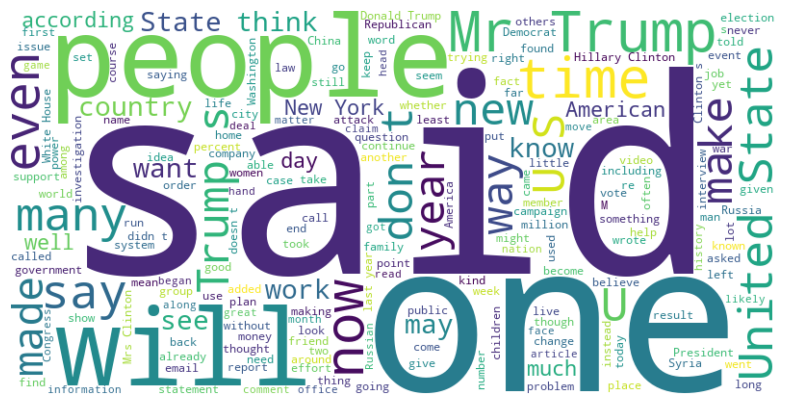

In [67]:
train_data_text = ' '.join(train_data['text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(train_data_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [68]:
random_seed = 42
X_train, X_test, y_train, y_test = train_test_split(train_data['text'], 
                                                    train_data['label'], 
                                                    test_size = 0.2,
                                                    random_state=random_seed)

DATA PROCESSING

In [69]:
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Tokenize
    tokens = word_tokenize(text)

    # Remove stopwords
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words]
    
    # Apply stemming
    stemmed_tokens = [stemmer.stem(word) for word in filtered_tokens]
    return ' '.join(stemmed_tokens)

preprocessed_X_train = X_train.apply(preprocess_text)
preprocessed_X_test = X_test.apply(preprocess_text)

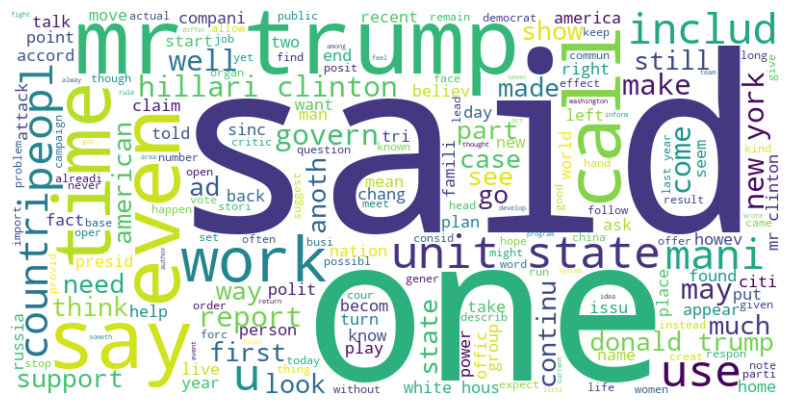

In [70]:
preprocessed_X_text = ' '.join(preprocessed_X_train)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(preprocessed_X_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Confusion Matrix Plot

In [71]:
def plot_confusion_matrix(conf_matrix, label):
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Predicted 0", "Predicted 1"], yticklabels=["Actual 0", "Actual 1"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - {label}")
    plt.show()

Learning Curve Plot

In [72]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

Logistic Regression Pipelines

TF-IDF Vectorization

In [136]:
lr_tf_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('logreg', LogisticRegression(max_iter=500))
])

lr_tf_param_grid = {
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'logreg__C': [0.1, 1],
    'logreg__solver': ['liblinear', 'lbfgs']
}

lr_tf_grid_search = GridSearchCV(lr_tf_pipeline, lr_tf_param_grid, cv=5, scoring='accuracy')
lr_tf_grid_search.fit(preprocessed_X_train, y_train)

print("Best Parameters:", lr_tf_grid_search.best_params_)
print("Best Accuracy:", lr_tf_grid_search.best_score_)

Best Parameters: {'logreg__C': 1, 'logreg__solver': 'liblinear', 'tfidf__ngram_range': (1, 2)}
Best Accuracy: 0.9485190569344987


In [137]:
lr_tf_predictions = lr_tf_grid_search.best_estimator_.predict(preprocessed_X_test)

Test Accuracy: 0.9499157235733204

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      2079
           1       0.96      0.94      0.95      2074

    accuracy                           0.95      4153
   macro avg       0.95      0.95      0.95      4153
weighted avg       0.95      0.95      0.95      4153


Confusion Matrix:


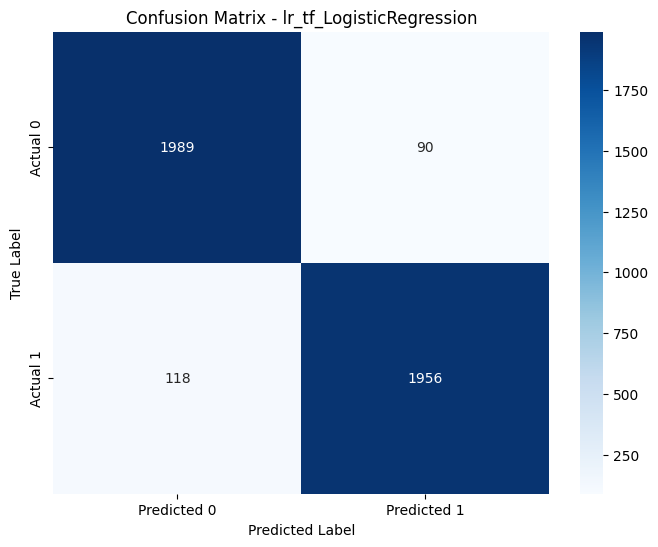

In [138]:
lr_tf_accuracy = accuracy_score(y_test, lr_tf_predictions)
print("Test Accuracy:", lr_tf_accuracy)

print("\nClassification Report:")
print(classification_report(y_test, lr_tf_predictions))

print("\nConfusion Matrix:")
plot_confusion_matrix(confusion_matrix(y_test, lr_tf_predictions), "lr_tf_LogisticRegression")

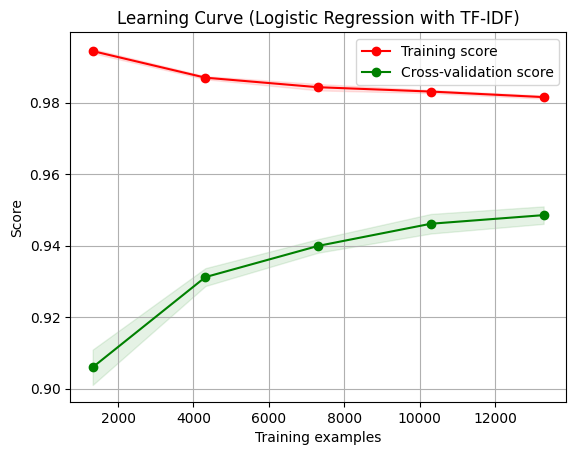

In [139]:
lr_tf_learning_curve_title = "Learning Curve (Logistic Regression with TF-IDF)"
plot_learning_curve(lr_tf_grid_search.best_estimator_, lr_tf_learning_curve_title,
                    preprocessed_X_train, y_train, cv=5)
plt.show()

Count Vectorization

In [130]:
lr_cv_pipeline = Pipeline([
    ('count_vectorizer', CountVectorizer()),
    ('logreg', LogisticRegression(max_iter=500))
])

lr_cv_param_grid = {
    'count_vectorizer__ngram_range': [(1, 1), (1, 2)],
    'logreg__C': [0.1, 1],
    'logreg__solver': ['liblinear', 'lbfgs']
}

lr_cv_grid_search = GridSearchCV(lr_cv_pipeline, lr_cv_param_grid, cv=5, scoring='accuracy')
lr_cv_grid_search.fit(preprocessed_X_train, y_train)

print("Best Parameters:", lr_cv_grid_search.best_params_)
print("Best Accuracy:", lr_cv_grid_search.best_score_)

Best Parameters: {'count_vectorizer__ngram_range': (1, 2), 'logreg__C': 0.1, 'logreg__solver': 'liblinear'}
Best Accuracy: 0.9568882710701481


In [131]:
lr_cv_predictions = lr_cv_grid_search.best_estimator_.predict(preprocessed_X_test)

Test Accuracy: 0.9614736335179388

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96      2079
           1       0.95      0.97      0.96      2074

    accuracy                           0.96      4153
   macro avg       0.96      0.96      0.96      4153
weighted avg       0.96      0.96      0.96      4153


Confusion Matrix:


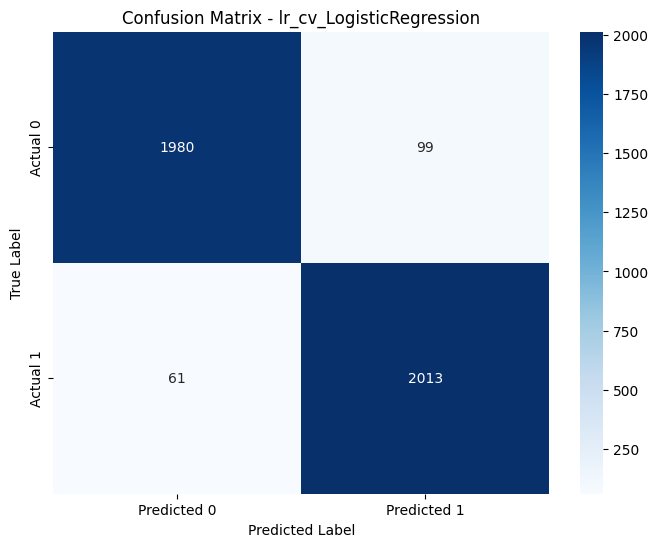

In [132]:
lr_cv_accuracy = accuracy_score(y_test, lr_cv_predictions)
print("Test Accuracy:", lr_cv_accuracy)

print("\nClassification Report:")
print(classification_report(y_test, lr_cv_predictions))

print("\nConfusion Matrix:")
plot_confusion_matrix(confusion_matrix(y_test, lr_cv_predictions), "lr_cv_LogisticRegression")

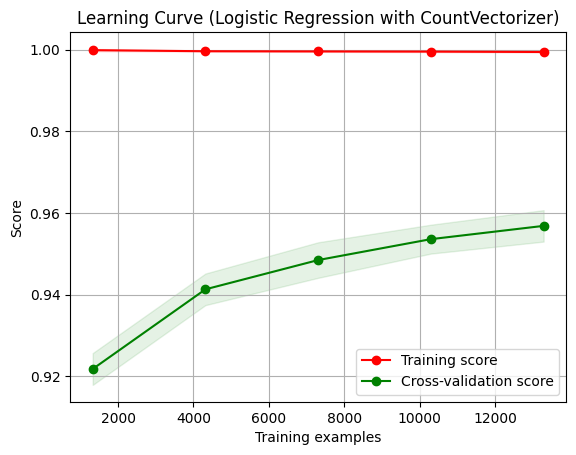

In [133]:
lr_cv_learning_curve_title = "Learning Curve (Logistic Regression with CountVectorizer)"
plot_learning_curve(lr_cv_grid_search.best_estimator_, lr_cv_learning_curve_title,
                    preprocessed_X_train, y_train, cv=5)
plt.show()

Word2Vec

In [81]:
tokenized_X_train = X_train.apply(word_tokenize)
tokenized_X_test = X_test.apply(word_tokenize)

stop_words = set(stopwords.words('english'))
filtered_X_train = tokenized_X_train.apply(lambda x: [word for word in x if word.lower() not in stop_words])
filtered_X_test = tokenized_X_test.apply(lambda x: [word for word in x if word.lower() not in stop_words])

word2vec_model = Word2Vec(sentences=filtered_X_train, vector_size=200, window=10, min_count=2, workers=4)

In [82]:
def get_avg_vector(tokens, model, vector_size):
    vector_sum = np.zeros(vector_size)
    count = 0
    for word in tokens:
        if word in model.wv:
            vector_sum += model.wv[word]
            count += 1
    if count != 0:
        return vector_sum / count
    else:
        return np.zeros(vector_size)

# Get word vectors for training and testing data
word2vec_X_train = filtered_X_train.apply(lambda x: get_avg_vector(x, word2vec_model, 200))
word2vec_X_test = filtered_X_test.apply(lambda x: get_avg_vector(x, word2vec_model, 200))

# Convert word2vec vectors to arrays
word2vec_X_train_array = np.vstack(word2vec_X_train)
word2vec_X_test_array = np.vstack(word2vec_X_test)

In [165]:
lr_word2vec_pipeline = Pipeline([
    ('logreg', LogisticRegression(max_iter=500))
])

lr_word2vec_param_grid = {
    'logreg__C': [0.1, 1],
    'logreg__solver': ['liblinear', 'lbfgs']
}

lr_word2vec_grid_search = GridSearchCV(lr_word2vec_pipeline, lr_word2vec_param_grid, cv=5, scoring='accuracy')
lr_word2vec_grid_search.fit(word2vec_X_train_array, y_train)

print("Best Parameters:", lr_word2vec_grid_search.best_params_)
print("Best Accuracy:", lr_word2vec_grid_search.best_score_)

Best Parameters: {'logreg__C': 1, 'logreg__solver': 'lbfgs'}
Best Accuracy: 0.9648964564433256


In [166]:
lr_word2vec_predictions = lr_word2vec_grid_search.best_estimator_.predict(word2vec_X_test_array)

Test Accuracy: 0.9653262701661449

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      2079
           1       0.98      0.95      0.96      2074

    accuracy                           0.97      4153
   macro avg       0.97      0.97      0.97      4153
weighted avg       0.97      0.97      0.97      4153


Confusion Matrix:


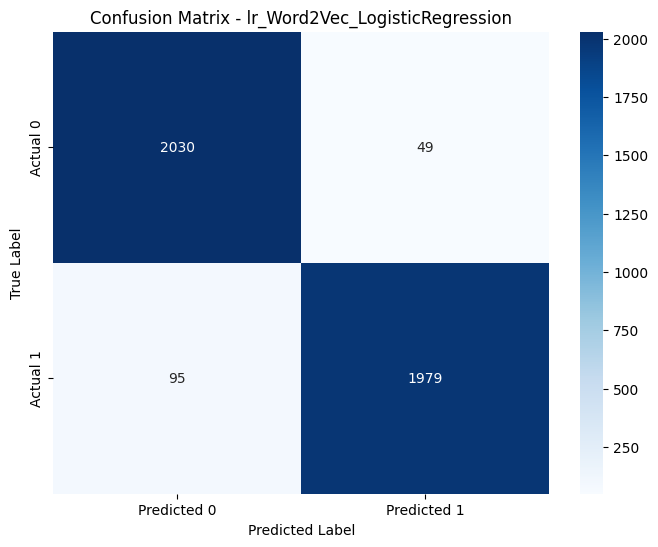

In [167]:
lr_word2vec_accuracy = accuracy_score(y_test, lr_word2vec_predictions)
print("Test Accuracy:", lr_word2vec_accuracy)

print("\nClassification Report:")
print(classification_report(y_test, lr_word2vec_predictions))

print("\nConfusion Matrix:")
plot_confusion_matrix(confusion_matrix(y_test, lr_word2vec_predictions), "lr_Word2Vec_LogisticRegression")

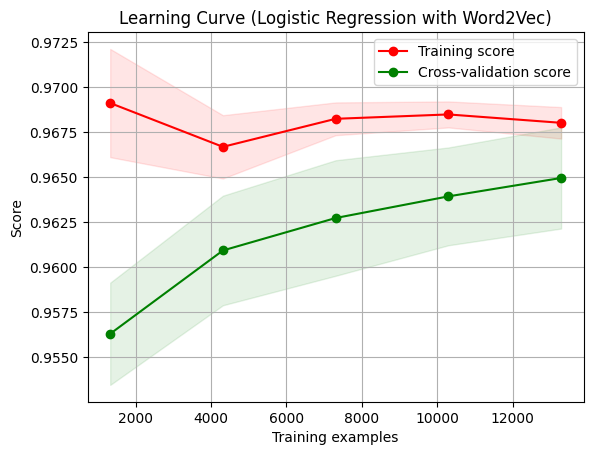

In [168]:
lr_word2vec_learning_curve_title = "Learning Curve (Logistic Regression with Word2Vec)"
plot_learning_curve(lr_word2vec_grid_search.best_estimator_, lr_word2vec_learning_curve_title,
                    word2vec_X_train_array, y_train, cv=5)
plt.show()

Naive Bayes

TF-IDF Vectorization

In [140]:
nb_tf_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

nb_tf_param_grid = {
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'nb__alpha': [0.1, 1]
}

nb_tf_grid_search = GridSearchCV(nb_tf_pipeline, nb_tf_param_grid, cv=5, scoring='accuracy')
nb_tf_grid_search.fit(preprocessed_X_train, y_train)

print("Best Parameters:", nb_tf_grid_search.best_params_)
print("Best Accuracy:", nb_tf_grid_search.best_score_)

Best Parameters: {'nb__alpha': 0.1, 'tfidf__ngram_range': (1, 1)}
Best Accuracy: 0.9096222187052962


In [141]:
nb_tf_predictions = nb_tf_grid_search.best_estimator_.predict(preprocessed_X_test)

Test Accuracy: 0.914038044786901

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.98      0.92      2079
           1       0.97      0.85      0.91      2074

    accuracy                           0.91      4153
   macro avg       0.92      0.91      0.91      4153
weighted avg       0.92      0.91      0.91      4153


Confusion Matrix:


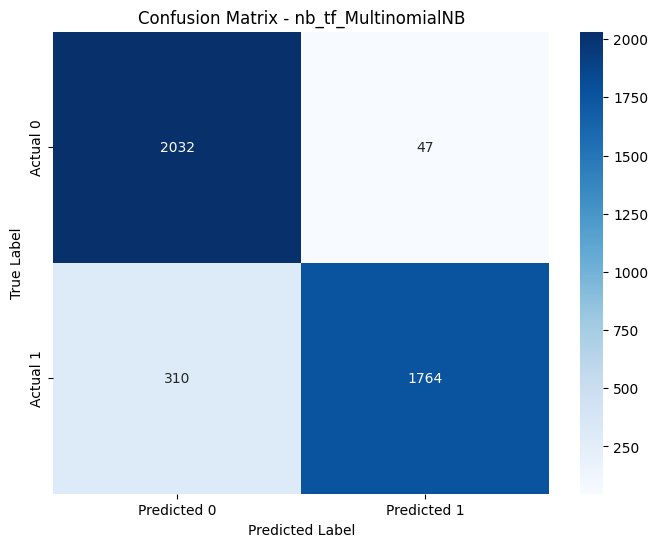

In [142]:
nb_tf_accuracy = accuracy_score(y_test, nb_tf_predictions)
print("Test Accuracy:", nb_tf_accuracy)

print("\nClassification Report:")
print(classification_report(y_test, nb_tf_predictions))

print("\nConfusion Matrix:")
plot_confusion_matrix(confusion_matrix(y_test, nb_tf_predictions), "nb_tf_MultinomialNB")

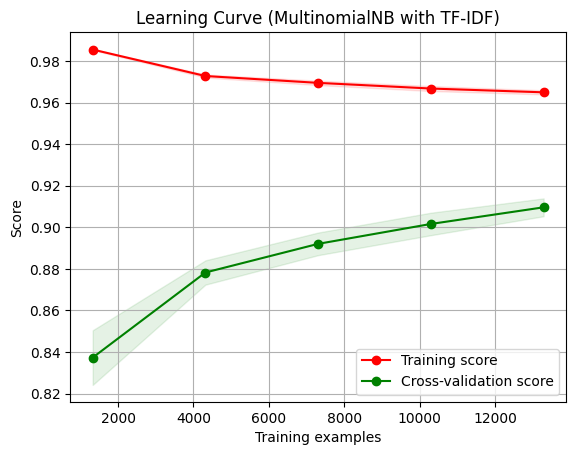

In [143]:
nb_tf_learning_curve_title = "Learning Curve (MultinomialNB with TF-IDF)"
plot_learning_curve(nb_tf_grid_search.best_estimator_, nb_tf_learning_curve_title,
                    preprocessed_X_train, y_train, cv=5)
plt.show()

Count Vectorization

In [144]:
nb_cv_pipeline = Pipeline([
    ('count_vectorizer', CountVectorizer()),
    ('nb', MultinomialNB())
])

nb_cv_param_grid = {
    'count_vectorizer__ngram_range': [(1, 1), (1, 2)],
    'nb__alpha': [0.1, 1]
}

nb_cv_grid_search = GridSearchCV(nb_cv_pipeline, nb_cv_param_grid, cv=5, scoring='accuracy')
nb_cv_grid_search.fit(preprocessed_X_train, y_train)

print("Best Parameters:", nb_cv_grid_search.best_params_)
print("Best Accuracy:", nb_cv_grid_search.best_score_)

Best Parameters: {'count_vectorizer__ngram_range': (1, 2), 'nb__alpha': 0.1}
Best Accuracy: 0.92569863099126


In [145]:
nb_cv_predictions = nb_cv_grid_search.best_estimator_.predict(preprocessed_X_test)

Test Accuracy: 0.9258367445220322

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.98      0.93      2079
           1       0.98      0.87      0.92      2074

    accuracy                           0.93      4153
   macro avg       0.93      0.93      0.93      4153
weighted avg       0.93      0.93      0.93      4153


Confusion Matrix:


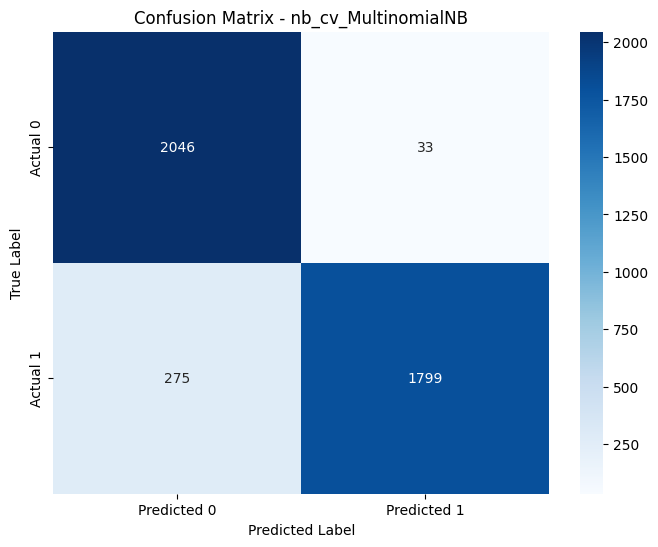

In [146]:
nb_cv_accuracy = accuracy_score(y_test, nb_cv_predictions)
print("Test Accuracy:", nb_cv_accuracy)

print("\nClassification Report:")
print(classification_report(y_test, nb_cv_predictions))

print("\nConfusion Matrix:")
plot_confusion_matrix(confusion_matrix(y_test, nb_cv_predictions), "nb_cv_MultinomialNB")

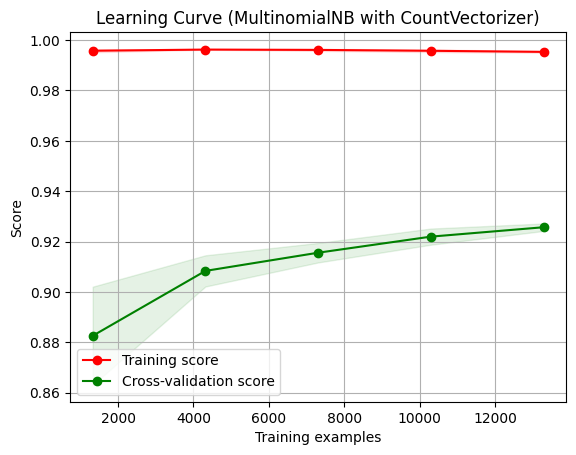

In [147]:
nb_cv_learning_curve_title = "Learning Curve (MultinomialNB with CountVectorizer)"
plot_learning_curve(nb_cv_grid_search.best_estimator_, nb_cv_learning_curve_title,
                    preprocessed_X_train, y_train, cv=5)
plt.show()

Word2Vec

MultinomialNB assumes non-negative input values, as it is typically used for discrete data like word counts in document classification. Since Word2Vec vectors can have negative values, it's not suitable for a MultinomialNB classifier.

Random Forest

TF-IDF Vectorization

In [118]:
rf_tf_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('rf', RandomForestClassifier())
])

rf_tf_param_grid = {
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'rf__n_estimators': [50, 100, 200],
    'rf__max_depth': [None, 10, 20, 30],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4]
}

rf_tf_grid_search = GridSearchCV(rf_tf_pipeline, rf_tf_param_grid, cv=5, scoring='accuracy')
rf_tf_grid_search.fit(preprocessed_X_train, y_train)

print("Best Parameters:", rf_tf_grid_search.best_params_)
print("Best Accuracy:", rf_tf_grid_search.best_score_)

Best Parameters: {'rf__max_depth': None, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 5, 'rf__n_estimators': 200, 'tfidf__ngram_range': (1, 1)}
Best Accuracy: 0.9237115497116573


In [119]:
rf_tf_predictions = rf_tf_grid_search.best_estimator_.predict(preprocessed_X_test)

Test Accuracy: 0.9154827835299784

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.95      0.92      2079
           1       0.95      0.88      0.91      2074

    accuracy                           0.92      4153
   macro avg       0.92      0.92      0.92      4153
weighted avg       0.92      0.92      0.92      4153


Confusion Matrix:


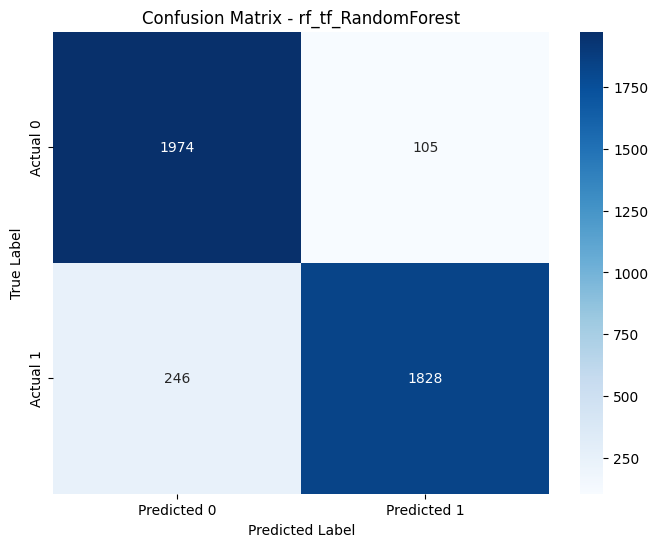

In [120]:
rf_tf_accuracy = accuracy_score(y_test, rf_tf_predictions)
print("Test Accuracy:", rf_tf_accuracy)

print("\nClassification Report:")
print(classification_report(y_test, rf_tf_predictions))

print("\nConfusion Matrix:")
plot_confusion_matrix(confusion_matrix(y_test, rf_tf_predictions), "rf_tf_RandomForest")

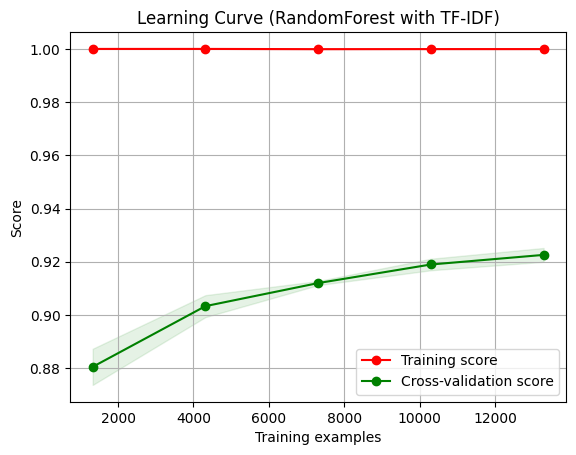

In [121]:
rf_tf_learning_curve_title = "Learning Curve (RandomForest with TF-IDF)"
plot_learning_curve(rf_tf_grid_search.best_estimator_, rf_tf_learning_curve_title,
                    preprocessed_X_train, y_train, cv=5)
plt.show()

Count Vectorization

In [122]:
rf_cv_pipeline = Pipeline([
    ('count_vectorizer', CountVectorizer()),
    ('rf', RandomForestClassifier())
])

rf_cv_param_grid = {
    'count_vectorizer__ngram_range': [(1, 1), (1, 2)],
    'rf__n_estimators': [50, 100, 200],
    'rf__max_depth': [None, 10, 20, 30],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4]
}

rf_cv_grid_search = GridSearchCV(rf_cv_pipeline, rf_cv_param_grid, cv=5, scoring='accuracy')
rf_cv_grid_search.fit(preprocessed_X_train, y_train)

print("Best Parameters:", rf_cv_grid_search.best_params_)
print("Best Accuracy:", rf_cv_grid_search.best_score_)

Best Parameters: {'count_vectorizer__ngram_range': (1, 1), 'rf__max_depth': None, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 200}
Best Accuracy: 0.9156429964861559


In [123]:
rf_cv_predictions = rf_cv_grid_search.best_estimator_.predict(preprocessed_X_test)

Test Accuracy: 0.9072959306525403

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.94      0.91      2079
           1       0.94      0.87      0.90      2074

    accuracy                           0.91      4153
   macro avg       0.91      0.91      0.91      4153
weighted avg       0.91      0.91      0.91      4153


Confusion Matrix:


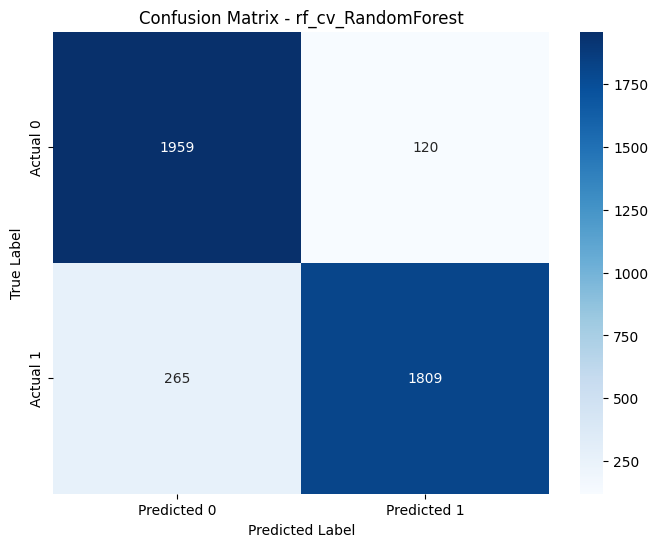

In [124]:
rf_cv_accuracy = accuracy_score(y_test, rf_cv_predictions)
print("Test Accuracy:", rf_cv_accuracy)

print("\nClassification Report:")
print(classification_report(y_test, rf_cv_predictions))

print("\nConfusion Matrix:")
plot_confusion_matrix(confusion_matrix(y_test, rf_cv_predictions), "rf_cv_RandomForest")

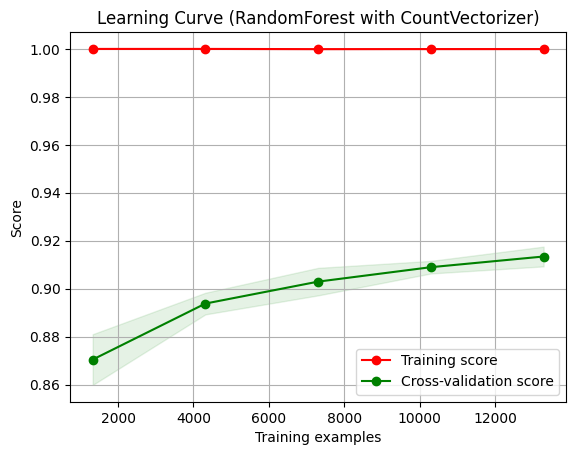

In [125]:
rf_cv_learning_curve_title = "Learning Curve (RandomForest with CountVectorizer)"
plot_learning_curve(rf_cv_grid_search.best_estimator_, rf_cv_learning_curve_title,
                    preprocessed_X_train, y_train, cv=5)
plt.show()

Word2Vec

In [58]:
rf_word2vec_pipeline = Pipeline([
    ('rf', RandomForestClassifier())
])

rf_word2vec_param_grid = {
    'rf__n_estimators': [50, 100, 200],
    'rf__max_depth': [None, 10, 20, 30],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4]
}

rf_word2vec_grid_search = GridSearchCV(rf_word2vec_pipeline, rf_word2vec_param_grid, cv=5, scoring='accuracy')
rf_word2vec_grid_search.fit(word2vec_X_train_array, y_train)

print("Best Parameters:", rf_word2vec_grid_search.best_params_)
print("Best Accuracy:", rf_word2vec_grid_search.best_score_)

Best Parameters: {'rf__max_depth': 20, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 5, 'rf__n_estimators': 100}
Best Accuracy: 0.9460502111877765


In [59]:
rf_word2vec_predictions = rf_word2vec_grid_search.best_estimator_.predict(word2vec_X_test_array)

Test Accuracy: 0.9424512400674211

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.96      0.94      2079
           1       0.96      0.93      0.94      2074

    accuracy                           0.94      4153
   macro avg       0.94      0.94      0.94      4153
weighted avg       0.94      0.94      0.94      4153


Confusion Matrix:


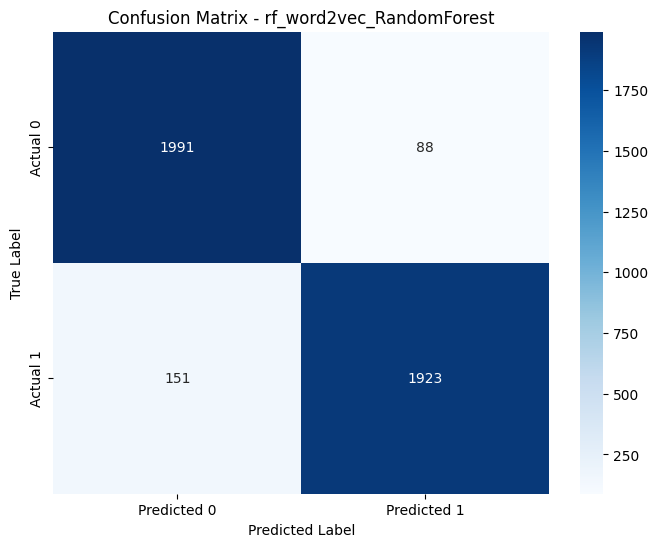

In [60]:
rf_word2vec_accuracy = accuracy_score(y_test, rf_word2vec_predictions)
print("Test Accuracy:", rf_word2vec_accuracy)

print("\nClassification Report:")
print(classification_report(y_test, rf_word2vec_predictions))

print("\nConfusion Matrix:")
plot_confusion_matrix(confusion_matrix(y_test, rf_word2vec_predictions), "rf_word2vec_RandomForest")

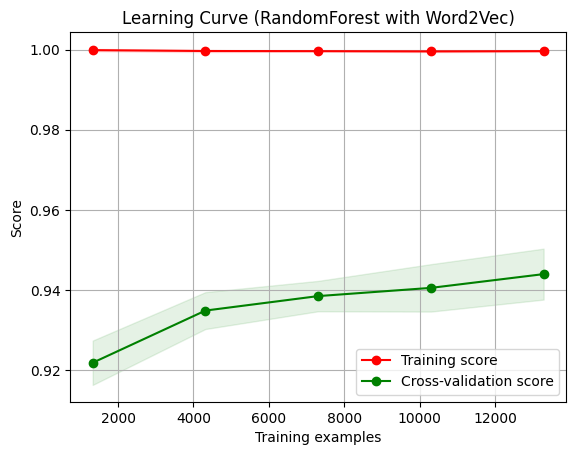

In [61]:
rf_word2vec_learning_curve_title = "Learning Curve (RandomForest with Word2Vec)"
plot_learning_curve(rf_word2vec_grid_search.best_estimator_, rf_word2vec_learning_curve_title,
                    word2vec_X_train_array, y_train, cv=5)
plt.show()

SVM

TF-IDF Vectorization

In [96]:
svc_tfidf_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('svc', SVC())
])

svc_tfidf_param_grid = {
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'svc__C': [0.1, 1],
    'svc__kernel': ['linear', 'rbf'],
}

svc_tfidf_grid_search = GridSearchCV(svc_tfidf_pipeline, svc_tfidf_param_grid, cv=5, scoring='accuracy')
svc_tfidf_grid_search.fit(preprocessed_X_train, y_train)

print("Best Parameters:", svc_tfidf_grid_search.best_params_)
print("Best Accuracy:", svc_tfidf_grid_search.best_score_)

Best Parameters: {'svc__C': 1, 'svc__kernel': 'linear', 'tfidf__ngram_range': (1, 2)}
Best Accuracy: 0.9660405813369793


In [97]:
svc_tfidf_predictions = svc_tfidf_grid_search.best_estimator_.predict(preprocessed_X_test)

Test Accuracy: 0.9662894293281965

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      2079
           1       0.97      0.96      0.97      2074

    accuracy                           0.97      4153
   macro avg       0.97      0.97      0.97      4153
weighted avg       0.97      0.97      0.97      4153


Confusion Matrix:


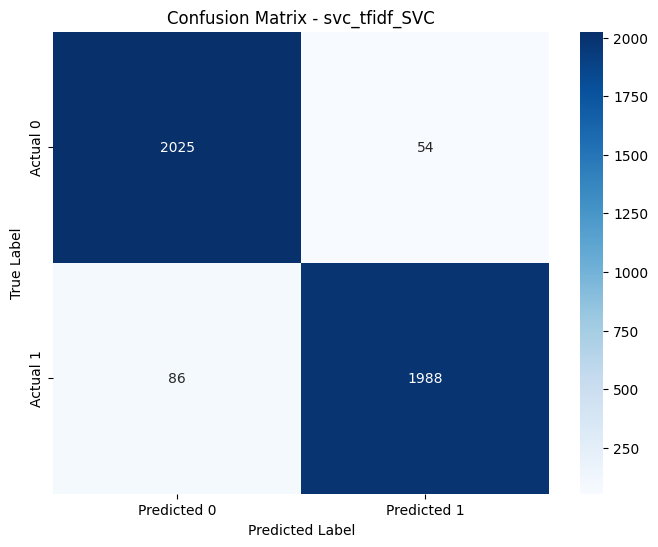

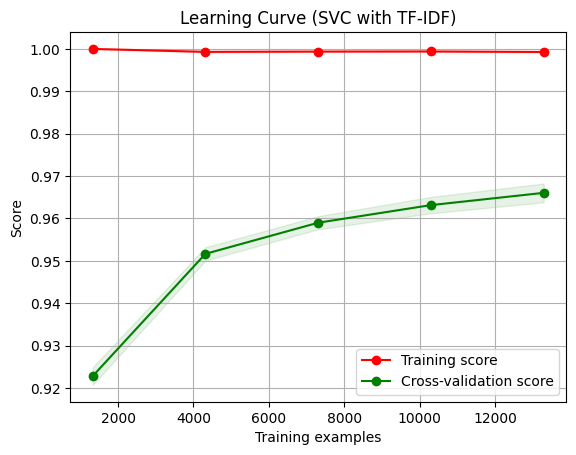

In [98]:
svc_tfidf_accuracy = accuracy_score(y_test, svc_tfidf_predictions)
print("Test Accuracy:", svc_tfidf_accuracy)

print("\nClassification Report:")
print(classification_report(y_test, svc_tfidf_predictions))

print("\nConfusion Matrix:")
plot_confusion_matrix(confusion_matrix(y_test, svc_tfidf_predictions), "svc_tfidf_SVC")
svc_tfidf_learning_curve_title = "Learning Curve (SVC with TF-IDF)"
plot_learning_curve(svc_tfidf_grid_search.best_estimator_, svc_tfidf_learning_curve_title,
                    preprocessed_X_train, y_train, cv=5)
plt.show()

Count Vectorization

In [151]:
svc_cv_pipeline = Pipeline([
    ('count_vectorizer', CountVectorizer()),
    ('svc', SVC())
])

svc_cv_param_grid = {
    'count_vectorizer__ngram_range': [(1, 1), (1, 2)],
    'svc__C': [0.1, 1],
    'svc__kernel': ['linear', 'rbf'],
}

svc_cv_grid_search = GridSearchCV(svc_cv_pipeline, svc_cv_param_grid, cv=5, scoring='accuracy')
svc_cv_grid_search.fit(preprocessed_X_train, y_train)

print("Best Parameters:", svc_cv_grid_search.best_params_)
print("Best Accuracy:", svc_cv_grid_search.best_score_)

Best Parameters: {'count_vectorizer__ngram_range': (1, 2), 'svc__C': 0.1, 'svc__kernel': 'linear'}
Best Accuracy: 0.9468927143616208


In [152]:
svc_cv_predictions = svc_cv_grid_search.best_estimator_.predict(preprocessed_X_test)

Test Accuracy: 0.954972309174091

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.95      0.95      2079
           1       0.95      0.96      0.96      2074

    accuracy                           0.95      4153
   macro avg       0.95      0.95      0.95      4153
weighted avg       0.95      0.95      0.95      4153


Confusion Matrix:


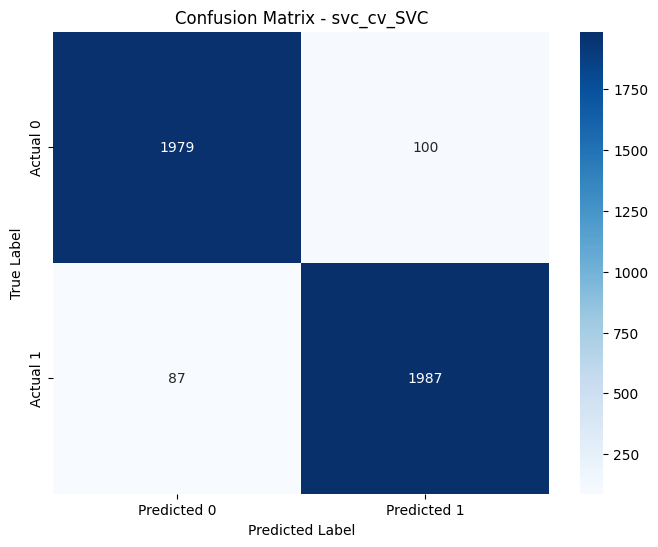

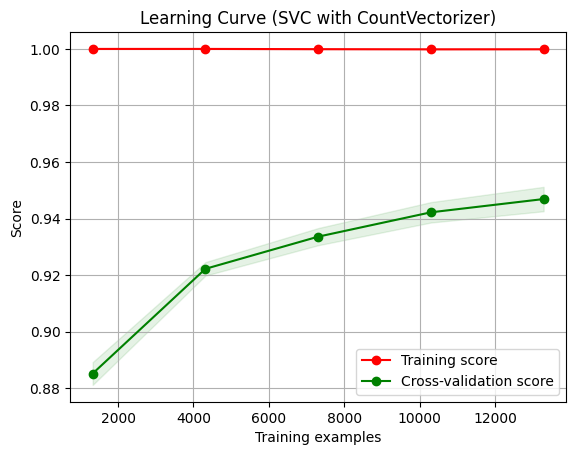

In [153]:
svc_cv_accuracy = accuracy_score(y_test, svc_cv_predictions)
print("Test Accuracy:", svc_cv_accuracy)

print("\nClassification Report:")
print(classification_report(y_test, svc_cv_predictions))

print("\nConfusion Matrix:")
plot_confusion_matrix(confusion_matrix(y_test, svc_cv_predictions), "svc_cv_SVC")
svc_cv_learning_curve_title = "Learning Curve (SVC with CountVectorizer)"
plot_learning_curve(svc_cv_grid_search.best_estimator_, svc_cv_learning_curve_title,
                    preprocessed_X_train, y_train, cv=5)
plt.show()

Word2Vec

In [148]:
svc_word2vec_pipeline = Pipeline([
    ('svc', SVC())
])

svc_word2vec_param_grid = {
    'svc__C': [0.1, 1],
    'svc__kernel': ['linear', 'rbf'],
    'svc__gamma': ['scale', 'auto'],
}

svc_word2vec_grid_search = GridSearchCV(svc_word2vec_pipeline, svc_word2vec_param_grid, cv=5, scoring='accuracy')
svc_word2vec_grid_search.fit(word2vec_X_train_array, y_train)

print("Best Parameters:", svc_word2vec_grid_search.best_params_)
print("Best Accuracy:", svc_word2vec_grid_search.best_score_)

Best Parameters: {'svc__C': 1, 'svc__gamma': 'scale', 'svc__kernel': 'linear'}
Best Accuracy: 0.9688103780495962


In [149]:
svc_word2vec_predictions = svc_word2vec_grid_search.best_estimator_.predict(word2vec_X_test_array)

Test Accuracy: 0.9686973272333254

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      2079
           1       0.98      0.96      0.97      2074

    accuracy                           0.97      4153
   macro avg       0.97      0.97      0.97      4153
weighted avg       0.97      0.97      0.97      4153


Confusion Matrix:


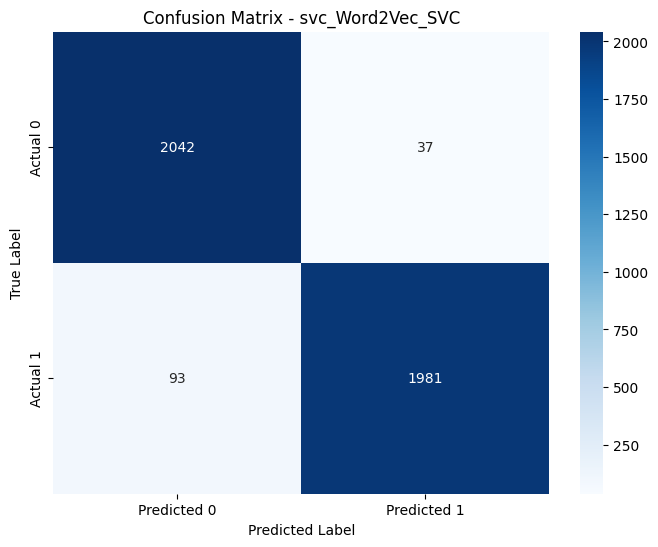

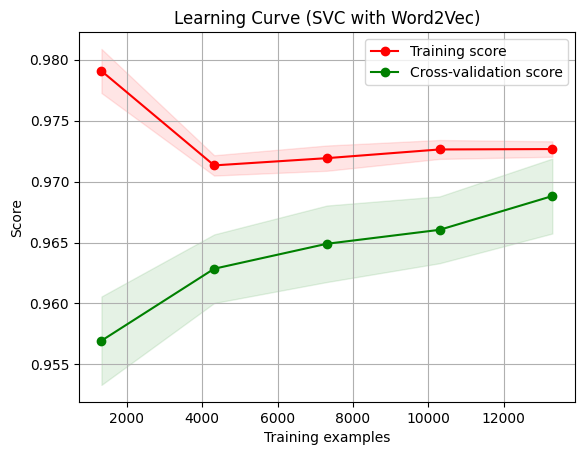

In [150]:
svc_word2vec_accuracy = accuracy_score(y_test, svc_word2vec_predictions)
print("Test Accuracy:", svc_word2vec_accuracy)

print("\nClassification Report:")
print(classification_report(y_test, svc_word2vec_predictions))

print("\nConfusion Matrix:")
plot_confusion_matrix(confusion_matrix(y_test, svc_word2vec_predictions), "svc_Word2Vec_SVC")
svc_word2vec_learning_curve_title = "Learning Curve (SVC with Word2Vec)"
plot_learning_curve(svc_word2vec_grid_search.best_estimator_, svc_word2vec_learning_curve_title,
                    word2vec_X_train_array, y_train, cv=5)
plt.show()

Bi-LSTM

In [154]:
embedding_dim = 100
max_words = 25000
max_len = 500

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(preprocessed_X_train)

X_train_sequences = tokenizer.texts_to_sequences(preprocessed_X_train)
X_test_sequences = tokenizer.texts_to_sequences(preprocessed_X_test)

X_train_padded = pad_sequences(X_train_sequences, maxlen=max_len, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_len, padding='post', truncating='post')

In [155]:
bi_lstm = Sequential()
bi_lstm.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len))
bi_lstm.add(Bidirectional(LSTM(100, return_sequences=True)))
bi_lstm.add(Bidirectional(LSTM(64)))
bi_lstm.add(Dense(128, activation='relu')),
bi_lstm.add(Dense(24, activation='relu')),
bi_lstm.add(Dense(1, activation='sigmoid'))

bi_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
bi_lstm.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 100)          2500000   
                                                                 
 bidirectional (Bidirection  (None, 500, 200)          160800    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               135680    
 onal)                                                           
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dense_1 (Dense)             (None, 24)                3096      
                                                                 
 dense_2 (Dense)             (None, 1)                

In [156]:
bi_lstm.fit(X_train_padded, y_train, epochs=5, batch_size=100, validation_split=0.2)

Epoch 1/5


133/133 [==============================] - 831s 6s/step - loss: 0.2541 - accuracy: 0.8834 - val_loss: 0.1158 - val_accuracy: 0.9588
Epoch 2/5
133/133 [==============================] - 838s 6s/step - loss: 0.0468 - accuracy: 0.9861 - val_loss: 0.0976 - val_accuracy: 0.9657
Epoch 3/5
133/133 [==============================] - 856s 6s/step - loss: 0.0155 - accuracy: 0.9952 - val_loss: 0.1572 - val_accuracy: 0.9539
Epoch 4/5
133/133 [==============================] - 878s 7s/step - loss: 0.0094 - accuracy: 0.9971 - val_loss: 0.1789 - val_accuracy: 0.9573
Epoch 5/5
133/133 [==============================] - 825s 6s/step - loss: 0.0075 - accuracy: 0.9980 - val_loss: 0.1742 - val_accuracy: 0.9594


In [190]:
bi_lstm_predictions = bi_lstm.predict(X_test_padded)
bi_lstm_binary_predictions = (bi_lstm_predictions > 0.5).astype(int)

_, accuracy = bi_lstm.evaluate(X_test_padded, y_test)
print("\nAccuracy:", accuracy)

print("\nClassification Report:")
print(classification_report(y_test, bi_lstm_binary_predictions))

130/130 [==============================] - 31s 240ms/step - loss: 0.1813 - accuracy: 0.9538

Accuracy: 0.9537683725357056

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      2079
           1       0.96      0.94      0.95      2074

    accuracy                           0.95      4153
   macro avg       0.95      0.95      0.95      4153
weighted avg       0.95      0.95      0.95      4153




Confusion Matrix:


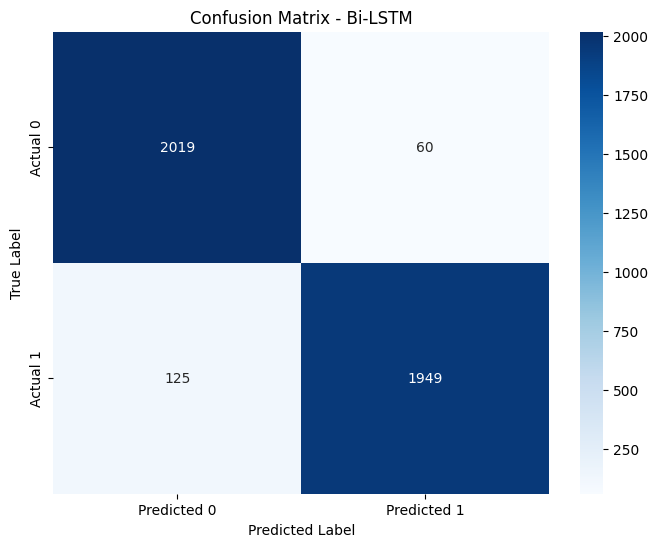

In [181]:
print("\nConfusion Matrix:")
plot_confusion_matrix(confusion_matrix(y_test, bi_lstm_binary_predictions), label="Bi-LSTM")

BERT

In [158]:
# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

tokenizer_config.json: 100%|██████████| 48.0/48.0 [00:00<00:00, 43.1kB/s]
c:\Users\bloo-\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:149: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\bloo-\.cache\huggingface\hub\models--bert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
vocab.txt: 100%|███

In [159]:
def tokenize_data(text_data, max_len=128):
    input_ids = []
    attention_masks = []

    for text in tqdm(text_data, desc="Tokenizing"):
        # Tokenize the text
        tokens = tokenizer.tokenize(tokenizer.decode(tokenizer.encode(text, add_special_tokens=True)))

        # Truncate or pad the tokens to the specified max length
        tokens = tokens[:max_len-2] + [tokenizer.pad_token] * max(0, max_len - 2 - len(tokens))

        # Convert tokens to input IDs
        input_id = tokenizer.convert_tokens_to_ids(tokens)

        # Create attention mask
        attention_mask = [1] * len(input_id)

        input_ids.append(input_id)
        attention_masks.append(attention_mask)

    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

In [160]:
max_sequence_length = 128
X_train_input_ids, X_train_attention_masks = tokenize_data(preprocessed_X_train.reset_index(drop=True), max_len=max_sequence_length)
X_test_input_ids, X_test_attention_masks = tokenize_data(preprocessed_X_test.reset_index(drop=True), max_len=max_sequence_length)

Tokenizing: 100%|██████████| 4153/4153 [00:55<00:00, 74.40it/s] 


In [161]:
# Convert labels to PyTorch tensors
y_train_tensor = torch.tensor(y_train.values)
y_test_tensor = torch.tensor(y_test.values)

# Create DataLoader for training and testing datasets
train_dataset = TensorDataset(X_train_input_ids, X_train_attention_masks, y_train_tensor)
test_dataset = TensorDataset(X_test_input_ids, X_test_attention_masks, y_test_tensor)

batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
optimizer = torch.optim.AdamW(bert_model.parameters(), lr=2e-5)
epochs = 3
training_losses = []

for epoch in range(epochs):
    bert_model.train()
    epoch_loss = 0.0
    for batch in tqdm(train_dataloader, desc="Training - Epoch {}".format(epoch + 1)):
        input_ids, attention_mask, labels = batch
        optimizer.zero_grad()
        outputs = bert_model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    # Calculate average epoch loss
    avg_epoch_loss = epoch_loss / len(train_dataloader)
    training_losses.append(avg_epoch_loss)

# Plot training loss
plt.plot(training_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

In [192]:
# Evaluate BERT model
bert_model.eval()
bert_predictions = []
with torch.no_grad():
    for batch in tqdm(test_dataloader, desc="Testing"):
        input_ids, attention_mask, labels = batch
        outputs = bert_model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        bert_predictions.extend(preds)

Testing: 100%|██████████| 130/130 [17:23<00:00,  8.02s/it]


In [193]:
accuracy = accuracy_score(y_test, bert_predictions)
print(f'Accuracy: {accuracy:.4f}')

print('Classification Report:')
print(classification_report(y_test, bert_predictions))

Accuracy: 0.9742
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      2079
           1       0.98      0.97      0.97      2074

    accuracy                           0.97      4153
   macro avg       0.97      0.97      0.97      4153
weighted avg       0.97      0.97      0.97      4153

Confusion Matrix:
[[2032   47]
 [  60 2014]]



Confusion Matrix:


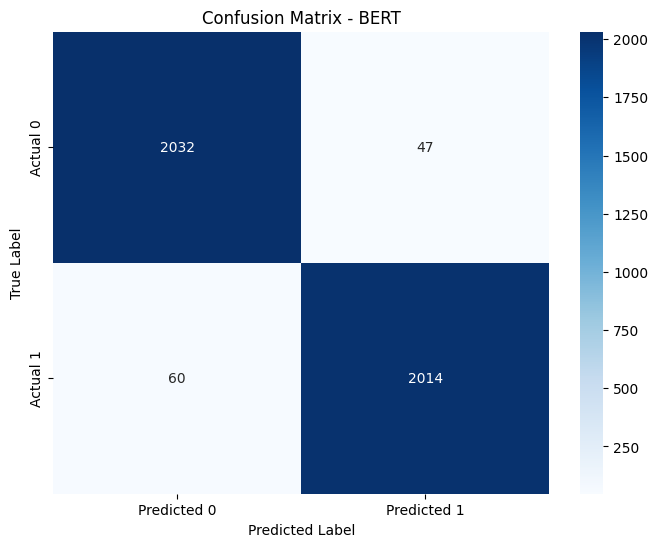

In [196]:
print("\nConfusion Matrix:")
plot_confusion_matrix(confusion_matrix(y_test, bert_predictions), label="BERT")

In [204]:
print(bert_model)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
# Save the trained BERT model and tokenizer to serve it via the web API
bert_model.save_pretrained('bert_model')
tokenizer.save_pretrained('bert_model')